In [1]:
import sympy
import numpy as np
from sympy.interactive.printing import init_printing
from sympy.matrices import Matrix, zeros
from sympy import symbols
init_printing()

In [2]:
class system():
    """
    
    """
    def __init__(self, lambda_count, v_count, need_g = False, start_computing = True, find_lambdas = False):
        self.need_g = need_g
        self.dimension = 3**(lambda_count+v_count)
        self.coef = symbols('lambda0:'+str(self.dimension))
        self.lambda_count = lambda_count
        self.v_count = v_count
        self.families = []
        self.M = Matrix()
        self.M_rank = 0
        self.nullspace = []
        self.states = []
        self.lambdas = []
        for i in range(self.dimension):
            self.states.append(system.th(i, lambda_count+v_count))
        self.gw = symbols('g1:'+str(self.lambda_count+self.v_count+1)+'_omega')
        self.gW = symbols('g1:'+str(self.lambda_count+self.v_count+1)+'_Omega')
        self.g = self.gw + self.gW
        if(start_computing):
            self.create_families()
            self.create_M()
            self.create_nullspace()
            self.basis = self.get_basis()
            #Крайне негативно сказывается на скорости выполнения - решение нелинейной системы уравнений
            if(find_lambdas):
                self.lambdas = self.create_lambda()

            
    def __str__(self):
        """
        Обработка текстового вывода общего вида системы
        """
        result = ''
        for i in range(len(self.states)-1):
            result+=(repr(self.coef[i]) + '|' + self.states[i] + '> + ')
        return result+ repr(self.coef[i+1]) +'|'+self.states[i+1]+'>'
    
    @staticmethod
    def th(num, count = 0):
        """
        Функция перевода числа в троичную систему счисления с заданной длиной числа (количеством незнячащих нулей)
        """
        base = 3
        new_num = ''
        zero_new_num = ''
        while num > 0:
            new_num = str(num % base) + new_num
            num //= base
        #В этом месте переменная new_num содержит переведенное число из десятичной системы в троичную
        for i in range(count - len(new_num)):
            zero_new_num+='0'
        zero_new_num+=new_num
        #Тип возвращаемого результата - строка (для избежания удаления незначащих нулей в начале числа)
        return zero_new_num
    
    def create_families(self):
        """
        Функция заполняет список families, вызывается только в конструкторе
        """
        for state in range(len(self.states)):
            family_o = [] #Семья по переходу вида омега малая
            for l_number in range(self.lambda_count):
                """
                переход 2 -> 1 для лямбда-типа атомов
                """
                if(self.states[state][l_number] == '1'):
                    family_o.append(self.states[state][:l_number]+
                                    '2'+self.states[state][l_number+1:])
            for v_number in range(self.v_count):
                """
                переход 1 -> 2 для v-типа атомов
                """
                if(self.states[state][self.lambda_count+v_number] == '0'):
                    family_o.append(self.states[state][:self.lambda_count+v_number]+
                                    '1'+self.states[state][self.lambda_count+v_number+1:])
            self.families.append(family_o)
            family_O = [] #Семья по переходу вида омега большая
            for l_number in range(self.lambda_count):
                """
                переход 2 -> 0 для лямбда-типа атомов
                """
                if(self.states[state][l_number] == '0'):
                    family_O.append(self.states[state][:l_number]+
                                    '2'+self.states[state][l_number+1:])
            for v_number in range(self.v_count):
                """
                переход 2 -> 0 для v-типа атомов
                """
                if(self.states[state][self.lambda_count+v_number] == '0'):
                    family_O.append(self.states[state][:self.lambda_count+v_number]+
                                    '2'+self.states[state][self.lambda_count+v_number+1:])
                    
            self.families.append(family_O)

    def create_M(self):
        """
        Функция вызывается только в конструкторе
        Создает матрицу, определяющую систему уравнений относительно лямбда и вычисляет ее ранг
        """
        self.M = zeros(2*self.dimension, self.dimension)
        for row in range(2*self.dimension):
            for col in range(self.dimension):
                if(system.th(col, self.lambda_count+self.v_count) in self.families[row]):
                    
                    """
                    !!!Поскольку в рамках задачи значения g i-ых не влияют на ранг матрицы, принимаем их все равными 1
                    """
                    if(not self.need_g):
                        self.M[row, col] = 1
                    else:
                        if(row%2==0):
                            sd = 0
                            for i in range(self.lambda_count+self.v_count):
                                if(self.th(row, self.lambda_count+self.v_count)[i] != 
                                   self.th(col, self.lambda_count+self.v_count)[i]):
                                    sd = i
                            self.M[row, col] = self.g[sd]
                        else:
                            sd = 0
                            for i in range(self.lambda_count+self.v_count):
                                if(self.th(int(row/2), self.lambda_count+self.v_count)[i] != 
                                   self.th(col, self.lambda_count+self.v_count)[i]):
                                    sd = i
                            self.M[row, col] = self.g[self.lambda_count+self.v_count+sd]
        self.M_rank = self.M.rank()

        
    def create_nullspace(self):
        #Решение однородной СЛАУ - ядро матрицы коэффициентов:
        self.nullspace = self.M.nullspace()
        
        
    def darksubspace_dimension(self):
        """
        Возвращает размерность подпространства темных состояний
        """
        return self.dimension - self.M_rank
    
    def get_basis(self):
        coefs = Matrix(self.coef).T
        result = []
        for i in range(len(self.nullspace)):
            result.append((coefs*self.nullspace[i])[0])
        self.basis = result
        return result
    
    def get_basis_vectors(self):
        result = []   
        coefs = Matrix(self.coef)
        for i in range(self.dimension - self.M_rank):
            result.append(coefs.multiply_elementwise(self.nullspace[i]))
        return result    

    def create_lambda(self):
        s1 = self.get_basis_vectors()
        result = []
        coefs = Matrix(self.coef).T
        for i in range(self.darksubspace_dimension()):
            eq = 0
            for j in range(self.dimension):
                eq += s1[i][j]**2
            result.append(sympy.Eq(eq, 1))
        return sympy.solve(result, self.coef, dict = True)
    
    
    #Отладочная по сути функция для быстрого получения результата
    #Работает только при условии что need_g = False
    def get_basis_text(self):
        result = []
        for i in range(self.dimension - self.M_rank):
            vector = ""
            for j in range(self.dimension):
                if(self.nullspace[i][j] == -1):
                    vector += ('-' + self.th(j, self.lambda_count+self.v_count))
                if(self.nullspace[i][j] == 1):
                    vector += ('+' + self.th(j, self.lambda_count+self.v_count))
            if(len(vector) != self.lambda_count+self.v_count+1):
                result.append(vector)
            else:
                result.append(vector[1:])
        return(result)


In [15]:
s03 = system(lambda_count = 0, v_count = 3, need_g = True, start_computing = True, find_lambdas = True)

In [16]:
#Размерность подпространства темных состояний:
s03.darksubspace_dimension()

In [5]:
s1 = system(1, 2, need_g = False, start_computing = True, find_lambdas = True)

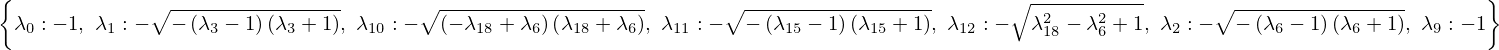

In [6]:
s1.lambdas[0]

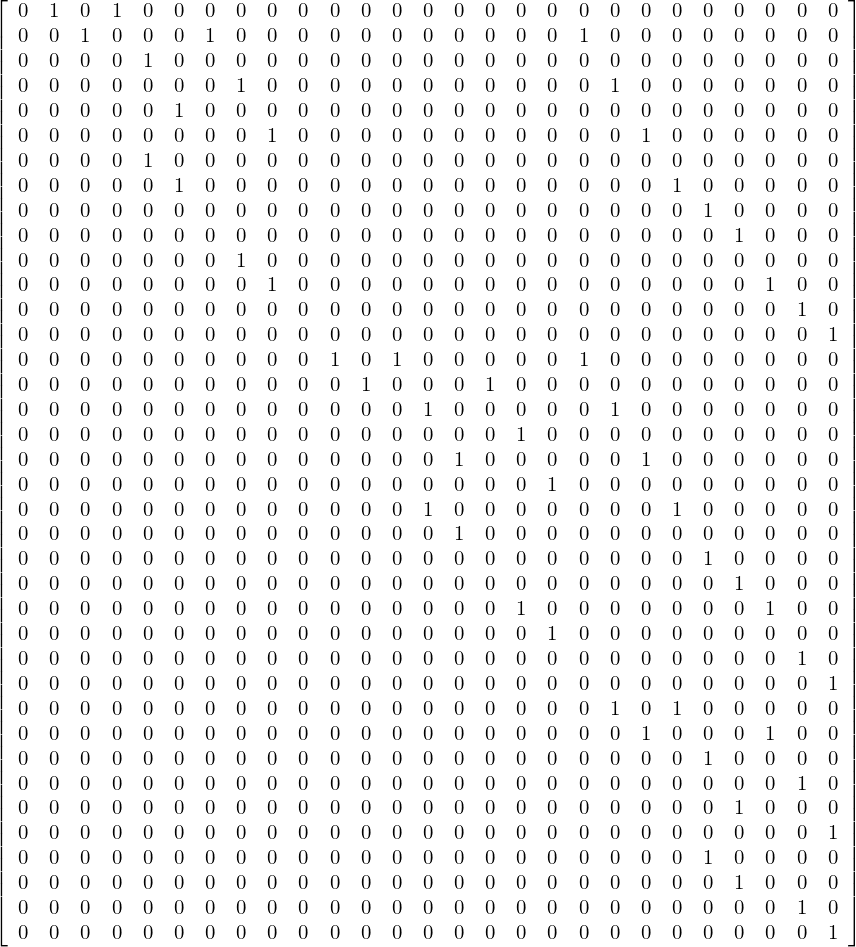

In [167]:
testM = s1.M
NewM = Matrix()
k = 0
for i in range(54):
    zero_count = 0
    for j in range(27):
        if(testM[i, j]==0):
            zero_count+=1
    if(zero_count!=27):
        NewM = NewM.row_insert(k, testM[i, :])
        k+=1
NewM

In [168]:
NewM_even = Matrix()
NewM_odd = Matrix()
for i in range(38):
    if(i%2==0):
        NewM_even = NewM_even.row_insert(i, NewM[i, :])
    else:
        NewM_odd = NewM_odd.row_insert(i, NewM[i, :])


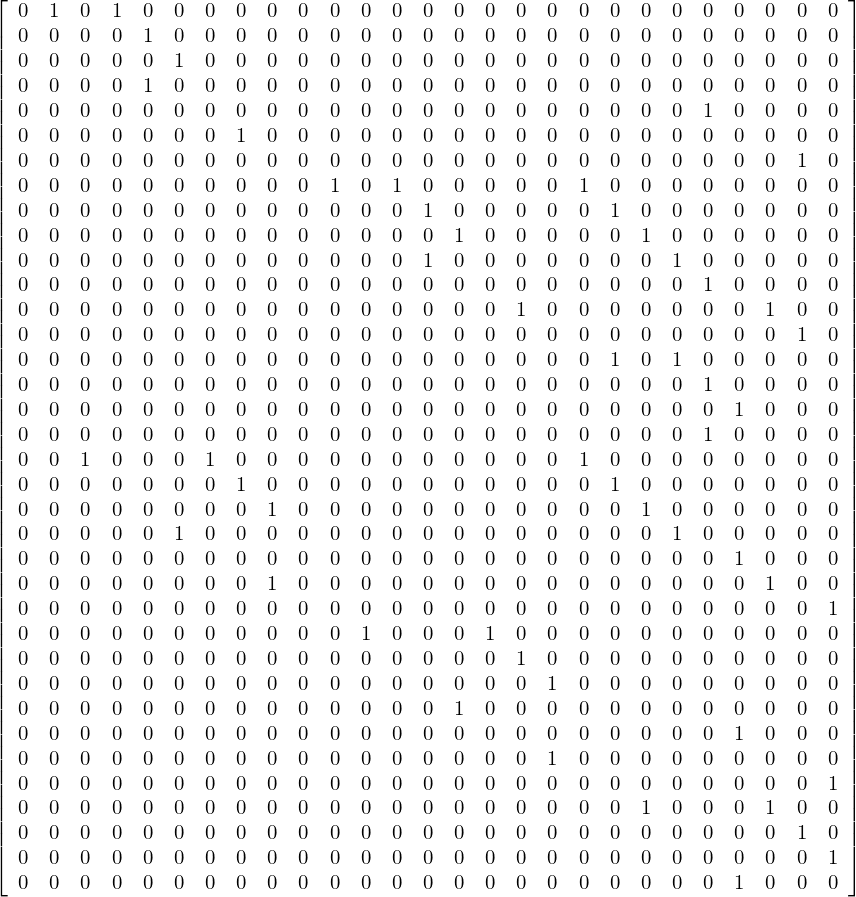

In [172]:

NewM_x = Matrix()

for i in range(18):
    NewM_x = NewM_x.row_insert(i, NewM_odd[i, :])
        
for i in range(18):
    NewM_x = NewM_x.row_insert(i, NewM_even[i, :])
    
NewM_x

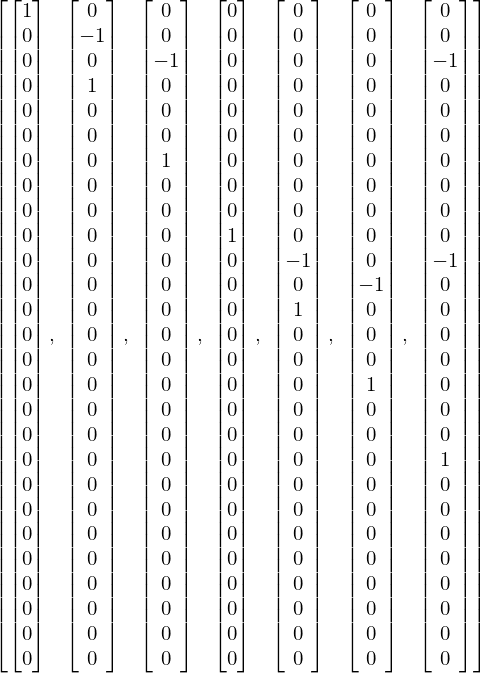

In [174]:
NewM_x.nullspace()

In [28]:
lambda_count = 1
v_count = 2

In [29]:
s = system(lambda_count = lambda_count, v_count = v_count, need_g = True, start_computing = True, find_lambdas = True)

In [30]:
#Размерность подпространства темных состояний:
s.darksubspace_dimension()

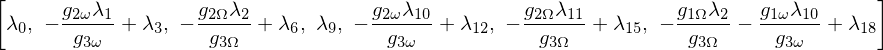

In [6]:
#Ненулевые коэффициенты при соответствующих базисных состояниях системы:
s.basis

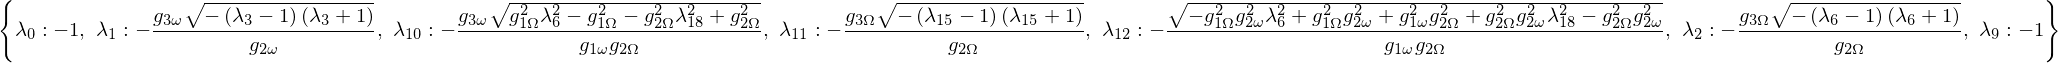

In [7]:
#Решение системы нелинейных уравнений (критерий нормировки):
s.lambdas[0]
#Количество найденных алгоритмом решений - len(s.lambdas)

In [10]:
%timeit system(lambda_count = lambda_count, v_count = v_count, need_g = False, start_computing = True, find_lambdas = False)

66.3 ms ± 6.78 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
%timeit s = system(lambda_count = lambda_count, v_count = v_count, need_g = True, start_computing = True, find_lambdas = True)

45.2 s ± 2.04 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%timeit s = system(lambda_count = lambda_count, v_count = v_count, need_g = True, start_computing = True, find_lambdas = False)

284 ms ± 18.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
